In [1]:
import pandas as pd

In [2]:
from scipy import stats
import numpy as np

## Remove outliers using Z score

def drop_coordinates_outliers(data):
    data = data.copy()
    print('Data shape before removing outliers: ', data.shape)
    data = data[((data.lat > 0.0)&(data.lon> 0.0))]
    z_lat, z_lon = np.abs(stats.zscore(data.lat)), np.abs(stats.zscore(data.lon))
    
    threshold = 2.5
    lat_outliers = np.where(z_lat > threshold)
    lon_outliers = np.where(z_lon > threshold)
    
    data_no_outliers = data.loc[~data.index.isin(np.concatenate((lat_outliers[0], lon_outliers[0])))].reset_index(drop=True)
    print('Data shape after removing outliers: ', data.shape)
    return data_no_outliers

### First of all we need to know the bounds of area which we will use for training

In [3]:
valid = pd.read_csv('./valid.csv')
valid = valid.drop_duplicates()

valid['hour'] = pd.to_datetime(valid['hour'], unit='s')

In [4]:
valid_no_outliers = drop_coordinates_outliers(data=valid.copy())
valid_no_outliers.head(5)

Data shape before removing outliers:  (709, 6)
Data shape after removing outliers:  (686, 6)


,hour,lat,lon,point,sum,error
0,2020-02-23 09:00:00,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402
1,2020-02-20 19:00:00,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291
2,2020-02-09 15:00:00,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735
3,2020-02-17 17:00:00,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735
4,2020-02-27 05:00:00,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735


In [5]:
LAT_MIN_BOUND, LAT_MAX_BOUND = valid_no_outliers.lat.min(), valid_no_outliers.lat.max()
LON_MIN_BOUND, LON_MAX_BOUND = valid_no_outliers.lon.min(), valid_no_outliers.lon.max()

In [6]:
print('Rectangle of interest: ', LAT_MIN_BOUND, LAT_MAX_BOUND, LON_MIN_BOUND, LON_MAX_BOUND)

Rectangle of interest:  59.82893394227072 60.03933228251395 30.14296935863054 30.53598229543283


## Read and process train data according to rectangle of interest

In [8]:
train = pd.read_csv('./train_data.zip')
print('Train before dropping duplicates: ', train.shape)

train = train.drop_duplicates()
print('Train after dropping duplicates: ', train.shape)

# Filter all locations with less than 5 events in it 
train = train.groupby("point").filter(lambda x: len(x) > 5)
print('Train after filtering out rare cubes: ', train.shape)

# Convert unix timestamp to normal time
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train = train.reset_index(drop=True)

Train before dropping duplicates:  (8526526, 12)
Train after dropping duplicates:  (8456776, 12)
Train after filtering out rare cubes:  (8454375, 12)


In [9]:
# Drop all cubes that are not included in rectangle of interest
train_processed = train[((train.lat <= LAT_MAX_BOUND)&(train.lat >= LAT_MIN_BOUND)&(train.lon <= LON_MAX_BOUND)&(train.lon >= LON_MIN_BOUND))]
print('Train after removing cubes which are out of rectangle of interest: ', train_processed.shape)

Train after removing cubes which are out of rectangle of interest:  (8295361, 12)


In [45]:
train_processed.head(5)

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point,lat_gird,lon_gird
0,2019-08-12 11:00:00,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,198,413
1,2019-08-12 00:00:00,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...,340,386
2,2019-08-12 00:00:00,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...,0,427
3,2019-08-12 00:00:00,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...,202,427
4,2019-08-12 00:00:00,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...,213,454


## Move coordinates to "image" grid

In [13]:
def lat_to_grid(inp):
    return round((LAT_MAX_BOUND - inp) / 0.0005)

def lon_to_grid(inp):
    return round((LON_MAX_BOUND - inp) / 0.0005)

In [14]:
train_processed.loc[:, 'lat_gird'] = train_processed['lat'].apply(lambda x: lat_to_grid(x))
train_processed.loc[:, 'lon_gird'] = train_processed['lon'].apply(lambda x: lon_to_grid(x))

/data/home/spushkov/.conda/envs/ent_rel_env/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [19]:
train_processed_x = train_processed.groupby(by=['timestamp', 'point']).size().reset_index(name='num_of_posts')
train_processed_x.sort_values('num_of_posts')

,timestamp,point,num_of_posts
0,2019-01-01 00:00:00,0101000020E610000002BF48199F3F3E4010C569574E02...,1
2094695,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4041CA35D0FCFC...,1
2094696,2019-09-06 13:00:00,0101000020E6100000B8194F56B7663E4053FFA7E47BF3...,1
2094698,2019-09-06 13:00:00,0101000020E6100000B8FFF2B7CB443E408991431816F7...,1
2094699,2019-09-06 13:00:00,0101000020E6100000BE54A7FF7E423E400D42027446FD...,1
...,...,...,...
1646443,2019-07-21 20:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,377
2562728,2019-10-19 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,393
2846146,2019-11-16 17:00:00,0101000020E610000050D352C225383E4030E11C588EFC...,401
1646846,2019-07-21 21:00:00,0101000020E6100000597DBB518C333E400262E887FEFD...,411


### Add lat and lon to grouped dataframe

In [20]:
tp = train_processed.drop_duplicates(['lon', 'lat', 'point'])

In [21]:
train_processed_x = pd.merge(left=tp[['lon', 'lat', 'point']], right=train_processed_x, on='point', how='right')

In [47]:
train_processed_x.head()

,lon,lat,point,timestamp,num_of_posts
0,30.248521,60.018016,0101000020E610000002BF48199F3F3E4010C569574E02...,2019-01-01,1
1,30.248521,59.850372,0101000020E610000002BF48199F3F3E40586790FFD8EC...,2019-01-01,1
2,30.239538,59.965226,0101000020E61000000614FD60523D3E400086058A8CFB...,2019-01-01,1
3,30.239538,59.858267,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,2019-01-01,2
4,30.239538,60.037089,0101000020E61000000614FD60523D3E40D800D455BF04...,2019-01-01,1


In [21]:
year_month_day_format = '%Y-%m-%d'
train_processed_x['Ymd'] = train_processed_x['timestamp'].apply(lambda x: x.strftime(year_month_day_format))

In [495]:
train_processed_x.to_pickle('./train_processed.pickle')

In [8]:
train_processed_x = pd.read_pickle('./train_processed.pickle')

In [61]:
valid_no_outliers.to_pickle('./valid_processed.pickle')

In [47]:
valid_no_outliers = pd.read_pickle('./valid_processed.pickle')

## Prepare data for LGBMRegressor

### Encode point

In [30]:
import holidays

In [20]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(train_processed_x['point'])+list(valid_no_outliers['point']))
train_processed_x['point_enc'] = le.transform(train_processed_x['point'])

In [52]:
valid_no_outliers['point_enc'] = le.transform(valid_no_outliers['point'])

### Extract features from datetime

In [31]:
ru_holidays = holidays.RU()

def extract_features(data):
    data["year"] = data["timestamp"].dt.year
    data["month"] = data["timestamp"].dt.month
    data["day"] = data["timestamp"].dt.day
    data["weekday"] = data["timestamp"].dt.weekday
    data["hour"] = data["timestamp"].dt.hour
    data["weekend"] = data["timestamp"].dt.weekday // 5
    data["holidays"] = data["timestamp"].apply(lambda x: int(x in ru_holidays))
    return data

In [33]:
train_processed_x = extract_features(train_processed_x)

In [37]:
train_processed_x.head()

,lon,lat,point,timestamp,num_of_posts,point_enc,year,month,day,weekday,hour,weekend,holidays
0,30.248521,60.018016,0101000020E610000002BF48199F3F3E4010C569574E02...,2019-01-01,1,4,2019,1,1,1,0,0,1
1,30.248521,59.850372,0101000020E610000002BF48199F3F3E40586790FFD8EC...,2019-01-01,1,19,2019,1,1,1,0,0,1
2,30.239538,59.965226,0101000020E61000000614FD60523D3E400086058A8CFB...,2019-01-01,1,120,2019,1,1,1,0,0,1
3,30.239538,59.858267,0101000020E61000000614FD60523D3E4074DD5BB2DBED...,2019-01-01,2,137,2019,1,1,1,0,0,1
4,30.239538,60.037089,0101000020E61000000614FD60523D3E40D800D455BF04...,2019-01-01,1,153,2019,1,1,1,0,0,1


In [48]:
valid_no_outliers = valid_no_outliers.rename({'hour': 'timestamp', 'sum': 'num_of_posts'}, axis=1)

In [50]:
valid_no_outliers = extract_features(valid_no_outliers.copy())

In [53]:
valid_no_outliers

,timestamp,lat,lon,point,num_of_posts,error,year,month,day,weekday,hour,weekend,holidays,point_enc
0,2020-02-23 09:00:00,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402,2020,2,23,6,9,1,1,771
1,2020-02-20 19:00:00,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291,2020,2,20,3,19,0,0,4511
2,2020-02-09 15:00:00,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735,2020,2,9,6,15,1,0,3887
3,2020-02-17 17:00:00,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735,2020,2,17,0,17,0,0,2169
4,2020-02-27 05:00:00,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735,2020,2,27,3,5,0,0,2342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,2020-02-02 16:00:00,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,7,2.254735,2020,2,2,6,16,1,0,2429
646,2020-02-07 04:00:00,59.950610,30.315895,0101000020E61000006141807FDE503E402B348A98ADF9...,8,6.754735,2020,2,7,4,4,0,0,2228
647,2020-02-14 05:00:00,59.933737,30.309158,0101000020E6100000268147F5244F3E407AB3D8B484F7...,6,4.754735,2020,2,14,4,5,0,0,870
648,2020-02-03 10:00:00,59.931487,30.358565,0101000020E61000008EADE7EACA5B3E40CAE971F73AF7...,8,1.421402,2020,2,3,0,10,0,0,3199


## LGBMRegressor

In [11]:
from lightgbm import LGBMRegressor

In [54]:
X_train, y_train = train_processed_x[['point_enc', 'year', 'month', 'day', 'weekday', 'hour', 'weekend', 'holidays']], train_processed_x['num_of_posts']
X_valid, y_valid = valid_no_outliers[['point_enc', 'year', 'month', 'day', 'weekday', 'hour', 'weekend', 'holidays']], valid_no_outliers['num_of_posts']

In [55]:
model = LGBMRegressor(n_jobs=25)
model.fit(X_train, y_train)


LGBMRegressor(n_jobs=25)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [57]:
predicted = model.predict(X_valid)

In [67]:
print('RMSE:', mean_squared_error(y_valid, predicted))
print("MAPE:", mean_absolute_percentage_error(y_valid, predicted))
print('Custom metric: ', np.mean(abs(predicted-y_valid)/predicted))

RMSE: 62.67240069230096
MAPE: 0.5934143461072732
Custom metric:  1.837237587668303


In [63]:
df_pred_true = pd.DataFrame({'true': y_valid, 'predicted': predicted})

In [64]:
df_pred_true['Custom_M'] = np.abs(df_pred_true['predicted'] - df_pred_true['true']) / df_pred_true['predicted']

## Read test data

In [68]:
test = pd.read_csv('./test.csv')

In [69]:
print('Test before dropping duplicates:', test.shape)
test = test.drop_duplicates()
print('Test after dropping duplicates:', test.shape)

Test before dropping duplicates: (700, 6)
Test after dropping duplicates: (700, 6)


In [70]:
test['timestamp'] = pd.to_datetime(test['hour'], unit='s')

In [74]:
# Drop all cubes that are not included in rectangle of interest
test_processed = test[((test.lat <= LAT_MAX_BOUND)&(test.lat >= LAT_MIN_BOUND)&(test.lon <= LON_MAX_BOUND)&(test.lon >= LON_MIN_BOUND))]
print('Test after removing cubes which are out of rectangle of interest: ', test_processed.shape)

Test after removing cubes which are out of rectangle of interest:  (700, 7)


In [75]:
test_processed = extract_features(test_processed)
test_processed = test_processed.rename({'sum': 'num_of_posts'}, axis=1)

In [77]:
test_processed['point_enc'] = le.transform(test_processed['point'])

In [78]:
test_processed

,hour,lat,lon,point,num_of_posts,error,timestamp,year,month,day,weekday,weekend,holidays,point_enc
0,10,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265,2020-02-26 10:00:00,2020,2,26,2,0,0,3547
1,11,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735,2020-02-17 11:00:00,2020,2,17,0,0,0,5030
2,16,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735,2020-02-12 16:00:00,2020,2,12,2,0,0,2429
3,13,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069,2020-02-12 13:00:00,2020,2,12,2,0,0,4691
4,13,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069,2020-02-15 13:00:00,2020,2,15,5,1,0,2259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,21,59.926986,30.331616,0101000020E61000009BAC04C2E4543E4070B5CC78A7F6...,6,0.754735,2020-02-18 21:00:00,2020,2,18,1,0,0,3530
696,15,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,15,1.215399,2020-02-18 15:00:00,2020,2,18,1,0,0,3872
697,8,59.937113,30.282208,0101000020E6100000328064CC3E483E400C288C4EF3F7...,20,18.754735,2020-02-17 08:00:00,2020,2,17,0,0,0,1122
698,8,59.933737,30.322632,0101000020E61000009E01B90998523E407AB3D8B484F7...,8,2.754735,2020-02-19 08:00:00,2020,2,19,2,0,0,3623


In [79]:
X_test, y_test = test_processed[['point_enc', 'year', 'month', 'day', 'weekday', 'hour', 'weekend', 'holidays']], test_processed['num_of_posts']

In [82]:
test_predicted = model.predict(X_test)

In [83]:
print('RMSE:', mean_squared_error(y_test, test_predicted))
print("MAPE:", mean_absolute_percentage_error(y_test, test_predicted))
print('Custom metric: ', np.mean(abs(test_predicted-y_test)/test_predicted))

RMSE: 65.30194982295582
MAPE: 0.5999656840325795
Custom metric:  1.8059154467632166


In [114]:
df_pred_true = pd.DataFrame({'true': y_test, 'predicted': test_predicted})
df_pred_true['custom_error'] = np.abs(df_pred_true['predicted'] - df_pred_true['true']) / df_pred_true['predicted']

In [115]:
df_pred_true = pd.concat([df_pred_true, test_processed[['point_enc', 'timestamp']]], axis=1)

In [116]:
df_pred_true

,true,predicted,custom_error,point_enc,timestamp
0,7,4.203236,0.665384,3547,2020-02-26 10:00:00
1,6,2.812785,1.133118,5030,2020-02-17 11:00:00
2,5,1.679937,1.976301,2429,2020-02-12 16:00:00
3,16,4.314327,2.708573,4691,2020-02-12 13:00:00
4,10,4.339450,1.304439,2259,2020-02-15 13:00:00
...,...,...,...,...,...
695,6,2.206492,1.719248,3530,2020-02-18 21:00:00
696,15,2.584371,4.804119,3872,2020-02-18 15:00:00
697,20,3.614502,4.533265,1122,2020-02-17 08:00:00
698,8,4.199872,0.904820,3623,2020-02-19 08:00:00


In [117]:
df_pred_true.custom_error.mean()

1.8059154467632166

In [89]:
from matplotlib import pyplot as plt

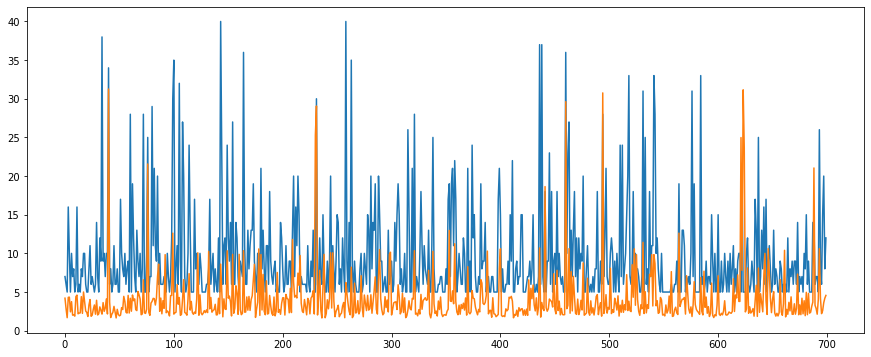

In [91]:
plt.figure(figsize=(15, 6))

plt.plot(df_pred_true.true)
plt.plot(df_pred_true.predicted)

In [123]:
test_processed.groupby('point_enc').num_of_posts.apply(len).sort_values()

point_enc
179      1
3571     1
3530     1
3527     1
3514     1
        ..
372     18
3503    18
4691    19
4362    19
5431    27
Name: num_of_posts, Length: 149, dtype: int64

In [124]:
the_most_popular_area = df_pred_true[df_pred_true.point_enc == 5431]
the_less_popular_area = df_pred_true[df_pred_true.point_enc == 1578]

<AxesSubplot:xlabel='timestamp'>

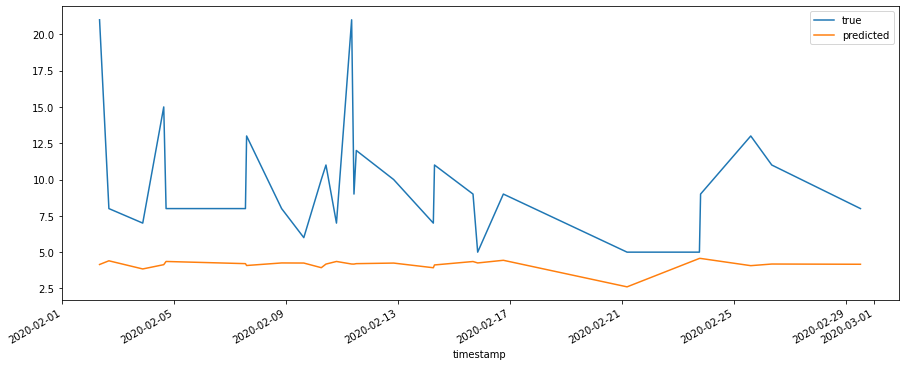

In [119]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
the_most_popular_area.plot( x = 'timestamp' , y = 'true', ax = ax )
the_most_popular_area.plot( x = 'timestamp' , y = 'predicted' , ax = ax )

<AxesSubplot:xlabel='timestamp'>

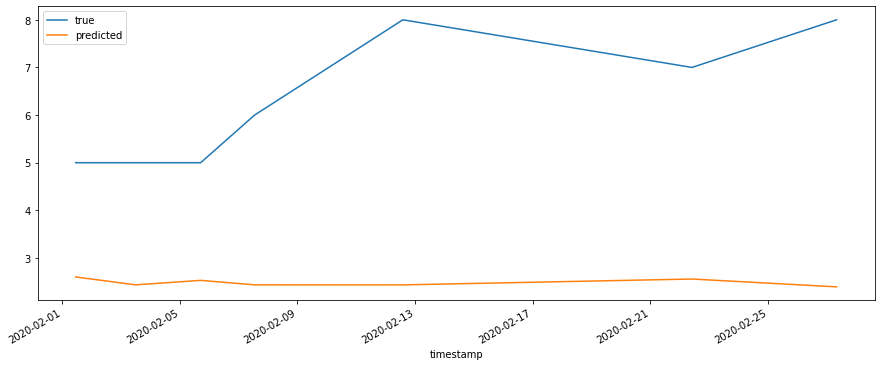

In [125]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)
the_less_popular_area.plot( x = 'timestamp' , y = 'true', ax = ax )
the_less_popular_area.plot( x = 'timestamp' , y = 'predicted' , ax = ax )